In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.svm import SVC
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None 

In [2]:
col_dirs = os.listdir('Collisions/')
print(col_dirs)

list_of_df = []
for col_run in col_dirs:
    list_of_df.append(pd.read_csv('Collisions/'+col_run+'/'+col_run+'_final2.csv'))
    
collisions_data = pd.concat(list_of_df)
collisions_data = collisions_data.reset_index(drop=True)
print(collisions_data.shape)

['321475', '321712', '321730', '321732', '321735', '321755', '321758', '321760', '321774', '321777', '321778', '321780', '321781', '321794', '321813', '321817', '321818', '321820', '321831', '321832', '321833', '321834', '321879', '321880', '321887', '321908', '321909', '321917', '321933', '321961', '321973', '321975', '321988', '321990', '322022', '322068', '322079', '322088', '322106', '322113', '322118', '322179', '322201', '322204', '322222', '322252', '322319', '322322', '322324', '322332', '322348', '322355', '322356', '322381', '322407', '322430', '322431', '322480', '322492', '322599', '322605', '322617', '322625', '322633', '323473', '323474', '323487', '323488', '323493', '323495', '323524', '323525', '323526', '323693', '323696', '323700', '323702', '323725', '323727', '323755', '323775', '323778', '323790', '323841', '323857', '323940', '323980', '323983', '323997', '324021', '324022', '324077', '324078', '324201', '324202', '324205', '324206', '324209', '324237', '324245',

In [3]:
collisions_data.head(5)

,run,chamber,wheel,sector,station,avg_cluster_size,occupancy,avg_bx_dist,avg_no_of_clusters,avg_multiplicity,lumisections,type,avg_efficiency,contains_zero_roll,rolls_count,fid_eff_ch_level
0,321475,W-2_RB1in_S01,-2,1,1,1.88926,85729,0.006567,1.00394,1.89670,2091,Col,53.435921,0,2,96.271114
1,321475,W-2_RB1out_S01,-2,1,1,1.83989,75899,0.006860,1.00387,1.84701,2091,Col,58.874134,0,2,97.754410
2,321475,W-2_RB2in_S01,-2,1,2,1.99387,91026,0.006966,1.00391,2.00167,2091,Col,81.179764,0,2,98.231281
3,321475,W-2_RB2out_S01,-2,1,2,1.85097,78148,0.011014,1.00278,1.85611,2091,Col,84.280207,0,3,98.210457
4,321475,W-2_RB3+_S01,-2,1,3,1.86637,36803,0.004361,1.00107,1.86836,2091,Col,92.292915,0,2,98.584396


# Analyzing the records with zero fiducial efficiency

In [4]:
zero_fid_rows = collisions_data.loc[collisions_data['fid_eff_ch_level'] == 0]

# Calculating the percentage of the zero-efficiency valued records in the dataset
data_size = collisions_data.shape[0]
zero_data_size = zero_fid_rows.shape[0]
zero_percentage = round((zero_data_size/data_size)*100,2)
print("Dataset for all the chambers contains approximately "+str(zero_percentage)+"% of records with 0 fiducial efficiency\n\n")

# Records with zero-valued fid efficiency
print(zero_fid_rows[:2])

Dataset for all the chambers contains approximately 8.4% of records with 0 fiducial efficiency


       run       chamber  wheel  sector  station  avg_cluster_size  occupancy  \
7   321475  W-2_RB4-_S01     -2       1        4               0.0          0   
12  321475  W-2_RB3+_S02     -2       2        3               0.0          0   

    avg_bx_dist  avg_no_of_clusters  avg_multiplicity  lumisections type  \
7           0.0                 0.0               0.0          2091  Col   
12          0.0                 0.0               0.0          2091  Col   

    avg_efficiency  contains_zero_roll  rolls_count  fid_eff_ch_level  
7              0.0                   1            2               0.0  
12             0.0                   1            2               0.0  


### 1. Looking at incorrect zero efficiency valued records

In [5]:
# Collecting records with fiducial efficiency equal to 0 when some 
# other attributes contains non-zero values. Meaning there are
# some discrepancies in efficiency computation since the chamber
# contains metrics that would otherwise result in fiducial efficiency
# greater than 0.

incorrect_zero_efficiency = zero_fid_rows[(zero_fid_rows['avg_cluster_size'] != 0) | (zero_fid_rows['occupancy'] != 0) | (zero_fid_rows['avg_bx_dist'] != 0) | (zero_fid_rows['avg_no_of_clusters'] != 0) | (zero_fid_rows['avg_multiplicity'] != 0)]
incorrect_zero_efficiency.head(5)

,run,chamber,wheel,sector,station,avg_cluster_size,occupancy,avg_bx_dist,avg_no_of_clusters,avg_multiplicity,lumisections,type,avg_efficiency,contains_zero_roll,rolls_count,fid_eff_ch_level
436,321475,W+2_RB2in_S07,2,7,2,2.03058,87447,0.009288,1.00343,2.03754,2091,Col,0.0,1,2,0.0
437,321475,W+2_RB2out_S07,2,7,2,1.86599,72115,0.007374,1.00218,1.87006,2091,Col,0.0,1,3,0.0
916,321712,W+2_RB2in_S07,2,7,2,2.08088,17417,0.013381,1.00264,2.08637,265,Col,0.0,1,2,0.0
917,321712,W+2_RB2out_S07,2,7,2,1.85333,14013,0.011771,1.00132,1.85578,265,Col,0.0,1,3,0.0
1396,321730,W+2_RB2in_S07,2,7,2,1.99378,19565,0.012331,1.00389,2.00153,282,Col,0.0,1,2,0.0


In [6]:
# As can be seen, almost all of the errors that occurred are
# computed of the chamber in the exact same location. It can be
# concluded that computation of fiducial efficiency is incorrect 
# when computing efficiency for Wheel +2, Sector 7, Station 2 IN and OUT
# chambers. Thus, needs further investigation, as all of these chambers
# for all the runs (20 chambers in total) contains incorrect values.

# The values should be probably removed when applying machine learning 
# models as they are incorrect. However,
# all the other records containing 0 fid efficiency seems to be appropriate,
# as all the other metrics are also zero.
print(" Chambers of incorrectly computed fiducial efficiency:")
print(incorrect_zero_efficiency['chamber'].value_counts())



# There are also few chambers that seem to have incorrect
# data assigned to them, such as values of 41 for avg_cluster size,
# occupancy, avg_multiplicity and so on. Can say that it's an 
# noise in the data that has to be removed as well for further 
# modeling. 
print("\n\n The outlier chambers containing fiducial efficiency of 0:")
incorrect_zero_efficiency[(incorrect_zero_efficiency['wheel'] != 2) | (incorrect_zero_efficiency['sector'] != 7) | (incorrect_zero_efficiency['station'] != 2)].head(5)

 Chambers of incorrectly computed fiducial efficiency:
W+2_RB2in_S07     132
W+2_RB2out_S07    132
W-1_RB2out_S07      8
W-2_RB4-_S05        3
W-2_RB4+_S01        2
W+2_RB4+_S01        2
W+2_RB4-_S01        1
W-2_RB3+_S04        1
W-1_RB4-_S01        1
Name: chamber, dtype: int64


 The outlier chambers containing fiducial efficiency of 0:


,run,chamber,wheel,sector,station,avg_cluster_size,occupancy,avg_bx_dist,avg_no_of_clusters,avg_multiplicity,lumisections,type,avg_efficiency,contains_zero_roll,rolls_count,fid_eff_ch_level
14549,321973,W-1_RB2out_S07,-1,7,2,3.0,3,3.0,1.0,3.0,1244,Col,0.0,1,2,0.0
18389,322106,W-1_RB2out_S07,-1,7,2,1.0,1,0.0,1.0,1.0,876,Col,0.0,1,2,0.0
23669,322332,W-1_RB2out_S07,-1,7,2,7.0,7,1.0,1.0,7.0,1079,Col,0.0,1,2,0.0
27029,322431,W-1_RB2out_S07,-1,7,2,5.0,5,2.0,1.0,5.0,1272,Col,0.0,1,2,0.0
40469,323857,W-1_RB2out_S07,-1,7,2,6.0,6,0.0,1.0,6.0,369,Col,0.0,1,2,0.0


### 2. Looking at possibly correct zero efficiency valued records

In [7]:
# Collecting records with fiducial efficiency equal to 0 when all the 
# other attributes (avg_cluster_size, occupancy, etc.) also contains
# zero values. Meaning the fiducial efficiency of zero for such chambers
# should be correct.

correct_zero_efficiency = zero_fid_rows[(zero_fid_rows['avg_cluster_size'] == 0) & (zero_fid_rows['occupancy'] == 0) & (zero_fid_rows['avg_bx_dist'] == 0) & (zero_fid_rows['avg_no_of_clusters'] == 0) & (zero_fid_rows['avg_multiplicity'] == 0)]
correct_zero_efficiency.head(5)

,run,chamber,wheel,sector,station,avg_cluster_size,occupancy,avg_bx_dist,avg_no_of_clusters,avg_multiplicity,lumisections,type,avg_efficiency,contains_zero_roll,rolls_count,fid_eff_ch_level
7,321475,W-2_RB4-_S01,-2,1,4,0.0,0,0.0,0.0,0.0,2091,Col,0.0,1,2,0.0
12,321475,W-2_RB3+_S02,-2,2,3,0.0,0,0.0,0.0,0.0,2091,Col,0.0,1,2,0.0
21,321475,W-2_RB3-_S03,-2,3,3,0.0,0,0.0,0.0,0.0,2091,Col,0.0,1,2,0.0
33,321475,W-2_RB4-_S04,-2,4,4,0.0,0,0.0,0.0,0.0,2091,Col,0.0,1,2,0.0
41,321475,W-2_RB4-_S05,-2,5,4,0.0,0,0.0,0.0,0.0,2091,Col,0.0,1,2,0.0


In [8]:
# It can be clearly seen that chambers in the outer layers
# (station 4 or 3) tend to have more zero valued fiducial
# efficiency rather than chambers in the first two Stations
# (Probably reasonable? as the detectors are further away
# and it's safe to assume they might be detecting less muons)
print("Stations with zero efficiency distribution:")
print(correct_zero_efficiency['station'].value_counts())

# There is no strong correlation between 0 fiducial efficiency
# and Sector numbers. However, Sectors 1 and 7 at the top
# seems reasonable based on their perpendicular position
# in the detector, receiving less cosmic muons?
# (however, what about sector 4 with most 0 efficiency records??)
print("\nSectors with zero efficiency distribution:")
print(correct_zero_efficiency['sector'].value_counts())


# No strong correlation between wheel and 0 fiducial efficiency
# whatsoever, except for the negative side of the barrel
# containing more 0-efficiency chambers.
print("\n Wheels with zero efficiency distribution:")
print(correct_zero_efficiency['wheel'].value_counts())

Stations with zero efficiency distribution:
4    3360
3    1395
2     261
1      24
Name: station, dtype: int64

Sectors with zero efficiency distribution:
4     1215
1      807
7      759
8      552
5      416
12     412
2      412
11     278
3      148
9       24
10      17
Name: sector, dtype: int64

 Wheels with zero efficiency distribution:
-1    2210
-2    1103
 0     708
 1     622
 2     397
Name: wheel, dtype: int64


### 3. Conclusion on zero efficiency valued records

Assuming that the records analyzed in 1. are damaged and they cannot be used for further computations it is safe to believe that the chamber will have the fiducial efficiency of 0 if and only if all the other attributes of such chamber contain 0 values, as inspected above in 2.


Having this in mind, we might consider dropping all the records containing zero fiducial efficiency value as they won't provide us with any relevant information when calculating the efficiency of a chamber, since only the records containing all the attributes (avg_cluster_size, occupancy, avg_bx_dist, avg_no_of_clusters, avg_multiplicity) of value zero will have a final fiducial efficiency equal to 0. 

Moreover, the data suggests that some actual fiducial efficiency values start at 40 (see cell below), thus, it is possible to assume that the 'correct' records with fiducial efficiency of 0 might be also discrepancies of the detectors, since the other fiducial efficiency values are nowhere close to 0 (closest one to be over 40).

In [9]:
# Looking at the histograms in EDA_Collisions we can see that the dataset
# contains almost no records that have fiducial efficiency greater that 0 
# and less than 40. To make sure, we check the exsiting data:


eff_0_to_40 = collisions_data[(collisions_data['fid_eff_ch_level']>0)&(collisions_data['fid_eff_ch_level']<40)]

print(collisions_data[(collisions_data['fid_eff_ch_level']>=80)&(collisions_data['fid_eff_ch_level']<90)].shape)

print("\n There are",eff_0_to_40.shape[0],"records containing fid efficiency between 0 and 40 in the dataset")
eff_0_to_40.head(5)

# As we can see, there are only 50 records with fid_eff between 0 and 40 for this dataset.

(3765, 16)

 There are 50 records containing fid efficiency between 0 and 40 in the dataset


,run,chamber,wheel,sector,station,avg_cluster_size,occupancy,avg_bx_dist,avg_no_of_clusters,avg_multiplicity,lumisections,type,avg_efficiency,contains_zero_roll,rolls_count,fid_eff_ch_level
2361,321735,W+2_RB4-_S07,2,7,4,1.80559,1551,0.008149,1.00468,1.81404,151,Col,50.000000,1,2,33.333336
9990,321833,W+2_RB4+_S01,2,1,4,1.52422,4059,0.009012,1.00150,1.52651,397,Col,41.666666,1,2,37.500000
11481,321880,W+2_RB4-_S07,2,7,4,1.78810,2945,0.023679,1.00061,1.78919,140,Col,36.111111,1,2,25.000000
11961,321887,W+2_RB4-_S07,2,7,4,1.81956,20077,0.010332,1.00100,1.82137,951,Col,56.666666,1,2,25.000000
13926,321961,W-2_RB4+_S01,-2,1,4,1.87192,10479,0.004109,1.00125,1.87426,375,Col,40.789474,1,2,38.461540


# -------- Problem formulation --------

As the problem itself suggests, predicting the efficiency of a chamber makes it a regression problem. As for regression model, it tends to be more difficult to minimize the objective function of such model. Therefore, it is decided to firstly try to solve a classification problem, splitting the dataset into N classes based on the fiducial efficiency into N equal sized buckets and trying out multiple classification models to see what output can be expected. 

Later on, the data will be used to train the regression models to be able to predict the numerical value for fiducial efficiency for a single chamber. 

Such model would help to quickly approximate the fiducial efficiency of a chamber after a Collision or a Cosmic run based on the initial metrics collected from the detectors (such as avg_cluster_size, occupancy, etc.). Also, the fiducial efficiency could be approximated for the chambers that were incorrectly assigned with the fiducial efficiency of 0 (such as the records analyzed in 1.) or if the 'correct' zero-valued records (analyzed in 2.) appears to be a discrepancy as well, such chambers could be assigned by a fiducial efficiency approximation of such model.

Modeling decisions will be based on the data analysis performed in **EDA_Collisions.ipynb** notebook.

# Prepare data for classification task (drop unnecessary columns, assign labels, standardize, shuffle, split into train/test/validate.)

Some attributes in the dataset are not useful for training the model. Such attributes would be:
* run (run number should not be an indicator for the efficiency computation)
* chamber (chamber name will be removed as all the chamber location data is stored within wheel, sector, station attributes)
* type (all the records used are Collisions type, therefore, the column has to be dropped)
* avg_efficiency (this is an efficiency retrieved from DQM system for the chambers, however, the project's aim is to compute a fiducial efficiency, thus, the column will have to be dropped)

The data will have to be split into N classes (buckets) based on their fiducial efficiency values to have an equal distribution for each class. 
For this case we'll try to use the existing data and split it into equal sized buckets based on the efficiency for current data. However, if there are some more substantial ranges of efficiency that could be split into, for example, weak efficiency, medium efficiency, and strong efficiency classes, we could augment data for each range to have an equal distribution. However, at the moment, it will be split into 3 classes by dividing existing data into equally distributed 3 buckets (see below, it gets us ranges (40.7, 91.2] for weak efficiency, (91.2, 97,2] for medium efficiency and (97.2, 100] for strong efficiency). The classes will be assigned with labes 0, 1 and 2 respectively.

As mentioned above, the zero valued records will have to be removed so that the model could use only the most correct data to be able to predict the efficiency as best as possible.

In [10]:
# print(collisions_data['contains_zero_roll'].value_counts())

### Dropping unnecessary columns and filtering records with non zero efficiency

In [11]:
# Try change occupancy and lumisection to occupancy_per_ls

collisions_data['occupancy_per_LS'] = collisions_data['occupancy'] / collisions_data['lumisections']

# Unnecessary columns are dropped. Copy in shaped_data for classification,
# collisions_data for regression.

print('original shape:',collisions_data.shape)
shaped_data = collisions_data.copy()
shaped_data.drop(['run', 'chamber', 'type', 'contains_zero_roll', 'rolls_count', 'avg_efficiency', 'occupancy', 'lumisections'], axis=1, inplace=True)

collisions_data.drop(['run', 'chamber', 'type', 'contains_zero_roll', 'rolls_count', 'avg_efficiency', 'occupancy', 'lumisections'], axis=1, inplace=True)
# shaped_data.drop(['run', 'chamber', 'type', 'contains_zero_roll', 'rolls_count', 'avg_efficiency'], axis=1, inplace=True)

print('collisions shape:', collisions_data.shape)
print('dropped shape:',shaped_data.shape)
shaped_data.head(5)

original shape: (63360, 17)
collisions shape: (63360, 9)
dropped shape: (63360, 9)


,wheel,sector,station,avg_cluster_size,avg_bx_dist,avg_no_of_clusters,avg_multiplicity,fid_eff_ch_level,occupancy_per_LS
0,-2,1,1,1.88926,0.006567,1.00394,1.89670,96.271114,40.999044
1,-2,1,1,1.83989,0.006860,1.00387,1.84701,97.754410,36.297944
2,-2,1,2,1.99387,0.006966,1.00391,2.00167,98.231281,43.532281
3,-2,1,2,1.85097,0.011014,1.00278,1.85611,98.210457,37.373505
4,-2,1,3,1.86637,0.004361,1.00107,1.86836,98.584396,17.600670


In [12]:
# The data with unnecessary columns removed will now be filtered to
# keep only records that contain the fiducial efficiency greater than 0.

data_with_eff = shaped_data.loc[shaped_data['fid_eff_ch_level'] > 0]
collisions_data = collisions_data.loc[collisions_data['fid_eff_ch_level']>0]
print(data_with_eff.shape)


# Get the range of the bins to split the data into three classes based
# on their fiducial efficiency values.

bins = pd.qcut(data_with_eff['fid_eff_ch_level'],3)
print(bins.value_counts())
interval_values = bins.cat.categories.right
print('Class splitting interval values: ',interval_values[0], interval_values[1], interval_values[2])

(58038, 9)
(0.033299999999999996, 96.173]    19346
(96.173, 97.582]                  19346
(97.582, 100.0]                   19346
Name: fid_eff_ch_level, dtype: int64
Class splitting interval values:  96.173 97.582 100.0


### Labels based on the efficiency value are added

In [13]:
# Creating a label column for the dataset, splitting into 3 equally distributed
# classes. label 0 - if efficiency is less than or equal to 91.22
# label 1 - if efficiency is greater than 91.22 and less than or equal to 97.22
# label 2 - if efficiency is greather than 97.22

def assign_label(fid_eff_val):
    if fid_eff_val <= interval_values[0]:
        return 0
    elif fid_eff_val <= interval_values[1]:
        return 1
    else:
        return 2
    
data_with_eff['label'] = data_with_eff['fid_eff_ch_level'].apply(lambda x: assign_label(x))

In [14]:
print(data_with_eff.shape)
print(data_with_eff['label'].value_counts())
data_with_eff.head(5)

(58038, 10)
2    19364
0    19346
1    19328
Name: label, dtype: int64


,wheel,sector,station,avg_cluster_size,avg_bx_dist,avg_no_of_clusters,avg_multiplicity,fid_eff_ch_level,occupancy_per_LS,label
0,-2,1,1,1.88926,0.006567,1.00394,1.89670,96.271114,40.999044,1
1,-2,1,1,1.83989,0.006860,1.00387,1.84701,97.754410,36.297944,2
2,-2,1,2,1.99387,0.006966,1.00391,2.00167,98.231281,43.532281,2
3,-2,1,2,1.85097,0.011014,1.00278,1.85611,98.210457,37.373505,2
4,-2,1,3,1.86637,0.004361,1.00107,1.86836,98.584396,17.600670,2


### Shuffle and  split data into Train/Validate/Test datasets

In [15]:
# Firstly, the column with fid_eff_ch_level will be dropped 
# since we're firstly training a classifier to predict one of the
# three classes that were assgined as labels 0, 1 and 2.
data_with_eff.drop(['fid_eff_ch_level'], axis=1, inplace=True)

# Also, shuffle the rows in the dataset
data_with_eff = shuffle(data_with_eff)
collisions_data = shuffle(collisions_data)

data_with_eff.head(5)

,wheel,sector,station,avg_cluster_size,avg_bx_dist,avg_no_of_clusters,avg_multiplicity,occupancy_per_LS,label
8213,-2,7,2,1.74907,0.006701,1.00186,1.75233,21.162162,2
12750,0,10,3,1.91406,0.004171,1.00093,1.91584,21.009639,0
35969,2,8,4,1.86943,0.004457,1.00105,1.87139,27.423077,2
54387,-1,7,1,2.01219,0.005391,1.00515,2.02255,56.420700,2
22357,0,11,3,1.82853,0.006405,1.00117,1.83066,39.503145,1


In [16]:
print(collisions_data.shape)
print(collisions_data.head(2))
col_list = collisions_data.columns
print(col_list)
print(data_with_eff.columns)

(58038, 9)
       wheel  sector  station  avg_cluster_size  avg_bx_dist  \
30313     -2      10        1           2.33083     0.003968   
26820      2       5        2           1.87865     0.008516   

       avg_no_of_clusters  avg_multiplicity  fid_eff_ch_level  \
30313             1.00441           2.34110         96.942020   
26820             1.00307           1.88442         97.568707   

       occupancy_per_LS  
30313         43.937008  
26820         54.302564  
Index(['wheel', 'sector', 'station', 'avg_cluster_size', 'avg_bx_dist',
       'avg_no_of_clusters', 'avg_multiplicity', 'fid_eff_ch_level',
       'occupancy_per_LS'],
      dtype='object')
Index(['wheel', 'sector', 'station', 'avg_cluster_size', 'avg_bx_dist',
       'avg_no_of_clusters', 'avg_multiplicity', 'occupancy_per_LS', 'label'],
      dtype='object')


In [17]:
# Separate the data into attributes dataFrame and
# labels dataFrame. X_data and Y_data

y_data = data_with_eff.iloc[:,-1:]
x_data = data_with_eff.iloc[:, 0:8]

y_data_reg = collisions_data.loc[:, collisions_data.columns == 'fid_eff_ch_level']
x_data_reg = collisions_data.loc[:, collisions_data.columns != 'fid_eff_ch_level']


# Split the data into Train/Validate/Test datasets.
# Train dataset will be used to train models, the data
# the models will be learning from. Validation set to be used
# for tuning the models, for finding the best hyperparameters. 
# Whereas Test dataset will be used for final evaluation once the
# models are optimized the most.

train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=1-train_ratio, random_state=1)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=1)

x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x_data_reg, y_data_reg, test_size=1-train_ratio, random_state=1)
x_val_reg, x_test_reg, y_val_reg, y_test_reg = train_test_split(x_test_reg, y_test_reg, test_size=test_ratio/(test_ratio + validation_ratio), random_state=1)

print("Classification Dataset is split into Train/Validate/Test subsets of size:")
print("train - %.2f%%" % ((x_train.shape[0]/(x_train.shape[0]+x_val.shape[0]+x_test.shape[0]))*100))
print("validate - %.2f%%" % ((x_val.shape[0]/(x_train.shape[0]+x_val.shape[0]+x_test.shape[0]))*100))
print("test - %.2f%%" % ((x_test.shape[0]/(x_train.shape[0]+x_val.shape[0]+x_test.shape[0]))*100))

print("Regression Dataset is split into Train/Validate/Test subsets of size:")
print("train - %.2f%%" % ((x_train_reg.shape[0]/(x_train_reg.shape[0]+x_val_reg.shape[0]+x_test_reg.shape[0]))*100))
print("validate - %.2f%%" % ((x_val_reg.shape[0]/(x_train_reg.shape[0]+x_val_reg.shape[0]+x_test_reg.shape[0]))*100))
print("test - %.2f%%" % ((x_test_reg.shape[0]/(x_train_reg.shape[0]+x_val_reg.shape[0]+x_test_reg.shape[0]))*100))

Classification Dataset is split into Train/Validate/Test subsets of size:
train - 70.00%
validate - 15.00%
test - 15.00%
Regression Dataset is split into Train/Validate/Test subsets of size:
train - 70.00%
validate - 15.00%
test - 15.00%


### Standardize data

In [18]:
# The data will be standardized so that the different
# attributes in the dataset will be within the same scale.
# So that one attribute would not contain more weight 
# than other attribute.

# Standardization transforms data such that its distribution
# whill have mean value of 0 and a standard deviation of 1. 
# It is performed feature/column wise. 
# x = (x-μ)/σ

# validation and test data will have to be standardized before testing
# by using mean and standard deviation of Train dataset.

#define scaler
scaler = preprocessing.StandardScaler().fit(x_train)
print(scaler.mean_)

# transform train data
x_train = scaler.transform(x_train)


# In practice, the scaler is stored in the preprocessing pipeline
# and new data arriving to the model will be scaled before
# sent into model black box to get prediction. However, right now,
# the validation data will be scaled at the same time.

x_val = scaler.transform(x_val)



reg_scaled = preprocessing.StandardScaler().fit(x_train_reg)
print(scaler.mean_)
x_train_reg = reg_scaled.transform(x_train_reg)
x_val_reg = reg_scaled.transform(x_val_reg)

[4.46758234e-02 6.45699798e+00 2.40803919e+00 1.91925156e+00
 1.45527074e-02 1.00275608e+00 1.92477573e+00 6.14639530e+01]
[4.46758234e-02 6.45699798e+00 2.40803919e+00 1.91925156e+00
 1.45527074e-02 1.00275608e+00 1.92477573e+00 6.14639530e+01]


# Models

## Classification

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [20]:
# First test run is performed on a lazy ML model that 
# finds the K neareast neighbors in the dataset for a given
# sample. The nearest neighbors are computed by calculating
# Euclidean distance between the validation sample and 
# samples in train dataset.

# n_neighbors = 1 means that the class will be assigned with 
# respect to the closest existing smaple in the train dataset.
model = KNeighborsClassifier(n_neighbors=7)
model.fit(x_train,y_train.values.ravel())

knn_pred = model.predict(x_val)
knn_accuracy = accuracy_score(y_val, knn_pred)

# An initial run on such model gives us an accuracy of 
# over 75%, meaning, more than 3 out of 4 of the validation
# samples are classified correctly based on their metrics
print("KNN Accuracy: ", knn_accuracy)

KNN Accuracy:  0.7925568573397657


In [23]:
incorrect_classes = {'label0':0, 'label1':0, 'label2':0}
count = 0
y_val_list = y_val['label'].tolist()

for i in range(len(y_val_list)):
    true_y = y_val_list[i]
    pred_y = knn_pred[i]
    if true_y != pred_y:
        count += 1
        if true_y == 0:
            incorrect_classes['label0'] += 1
        elif true_y == 1:
            incorrect_classes['label1'] += 1
        else:
            incorrect_classes['label2'] += 1

print("Number of misclassified samples:")
print(count)

print("\nNumber of missclasified samples by true label:")
print(incorrect_classes)

# It is quite obvious that the most missclassfied chambers are
# of label 1, since this class is in between two classes in
# in a very small range. Therefore, even classes 1 and 2 might
# be very similar based on their metrics and efficiency. 

# It is clear that label 0 was wrongly classified least times
# as it contains quite a large range of efficiency, thus, it should
# be easily predicting great part of its data. Because some records
# should be further away from the label 1 and label 2 data.

Number of misclassified samples:
1856

Number of missclasified samples by true label:
{'label0': 403, 'label1': 826, 'label2': 627}


In [26]:
# SVM Classifier
from sklearn.model_selection import cross_val_score
from sklearn import svm

clf = svm.SVC()
# scores = cross_val_score(clf, x_train, y_train.values.ravel(), cv=10)
# clf = clf.fit(x_train, y_train.values.ravel())

# print("SVM cross-validation scores:",scores)
# print("Expected classification accuracy on test set is:",(sum(scores)/len(scores)))

# clf = SVC(kernel='linear')
# clf = clf.fit(x_train, y_train.values.ravel())

In [28]:
clf.fit(x_train, y_train)
svm_predict = clf.predict(x_val)
svm_accuracy = accuracy_score(y_val, svm_predict)
print(svm_accuracy)

/cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5796002756719504


### Ensemble Learning

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(multi_class='ovr', max_iter=100)
rnd_clf = RandomForestClassifier(n_estimators=1000, max_depth=50)
# svm_clf = SVC()

for clf in (log_clf, rnd_clf):
    clf.fit(x_train, y_train.values.ravel())
    y_pred = clf.predict(x_val)
    print(clf.__class__.__name__,accuracy_score(y_val, y_pred))

/cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/sklearn/linear_model/logistic.py:430: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  warnings.warn("Default solver will be changed to 'lbfgs' in 0.22. "


LogisticRegression 0.41913622788881233
RandomForestClassifier 0.795543303468872


In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

dt_clf = DecisionTreeClassifier(random_state=0)
dt_clf.fit(x_train, y_train.values.ravel())
y_pred = dt_clf.predict(x_val)
print(dt_clf.__class__.__name__,accuracy_score(y_val, y_pred))


gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=11, random_state=0)
gb_clf.fit(x_train, y_train.values.ravel())
y_pred = gb_clf.predict(x_val)
print(gb_clf.__class__.__name__,accuracy_score(y_val, y_pred))

DecisionTreeClassifier 0.7452331725246956
GradientBoostingClassifier 0.7969216632207673


In [42]:
# Using three classifiers to collect the better overall performance when classifying data.
# This makes it an ensemble learning, where the model performance increases when using
# multiple classifiers together rather than single one of them separately

voting_clf = VotingClassifier(estimators=[('rf', rnd_clf), ('knn', model), ('gb', gb_clf)], voting='hard')
voting_clf.fit(x_train, y_train.values.ravel())
y_pred = voting_clf.predict(x_val)
print(voting_clf.__class__.__name__,accuracy_score(y_val, y_pred))

# However, the performance did not increase as much as could have been expected.

# voting_clf = VotingClassifier(estimators=[('rf', rnd_clf), ('dt', dt_clf), ('gb', gb_clf)], voting='hard')
# voting_clf.fit(x_train, y_train.values.ravel())
# y_pred = voting_clf.predict(x_val)
# print(voting_clf.__class__.__name__,accuracy_score(y_val, y_pred))

VotingClassifier 0.8050769584194808


In [43]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier()
xgb_clf.fit(x_train, y_train.values.ravel())
y_pred = xgb_clf.predict(x_val)
print(xgb_clf.__class__.__name__,accuracy_score(y_val, y_pred))

XGBClassifier 0.589478520560533


In [44]:
# Some basic hyperparameter tuning. Looking into output of using different values
# for criterion and max_depth of DecisionTreeClassifier.

criterion = ['gini', 'entropy']
max_depth = [20,22,24,26]

dt_clf = DecisionTreeClassifier(random_state=0)
dt_clf.fit(x_train, y_train.values.ravel())
train_pred = dt_clf.predict(x_train)
val_pred = dt_clf.predict(x_val)
print("Accuracy(training)",accuracy_score(y_train, train_pred))
print("Accuracy(validation)",accuracy_score(y_val, val_pred))

for crit in criterion:
    print("\nCriterion:", crit)
    for depth in max_depth:
        print("\ndepth:", depth)
        dt_clf = DecisionTreeClassifier(random_state=0, criterion = crit, max_depth=depth)
        dt_clf.fit(x_train, y_train.values.ravel())
        train_pred = dt_clf.predict(x_train)
        val_pred = dt_clf.predict(x_val)
        print("Accuracy(training)",accuracy_score(y_train, train_pred))
        print("Accuracy(validation)",accuracy_score(y_val, val_pred))


Accuracy(training) 1.0
Accuracy(validation) 0.7452331725246956

Criterion: gini

depth: 20
Accuracy(training) 0.9610348052971004
Accuracy(validation) 0.7532736044107512

depth: 22
Accuracy(training) 0.980751243046325
Accuracy(validation) 0.7483344819664599

depth: 24
Accuracy(training) 0.9921725003692217
Accuracy(validation) 0.7476453020905123

depth: 26
Accuracy(training) 0.9975139073499729
Accuracy(validation) 0.7451183092120377

Criterion: entropy

depth: 20
Accuracy(training) 0.9576871953921134
Accuracy(validation) 0.7546519641626465

depth: 22
Accuracy(training) 0.9791758972086841
Accuracy(validation) 0.753618194348725

depth: 24
Accuracy(training) 0.9906709988677201
Accuracy(validation) 0.7493682517803814

depth: 26
Accuracy(training) 0.9965047014227342
Accuracy(validation) 0.7455777624626694


In [45]:
gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=0.1, max_depth=11, random_state=0)
gb_clf.fit(x_train, y_train.values.ravel())
y_pred = gb_clf.predict(x_val)
print(gb_clf.__class__.__name__,accuracy_score(y_val, y_pred))

GradientBoostingClassifier 0.7880771881461062


## Keras NN Classifier

In [46]:
# from keras.models import Sequential
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from tensorflow.keras import regularizers
from keras.optimizers import adam
from tensorflow.keras.layers import Dropout
from math import sqrt

In [80]:
encoded_train_y = np_utils.to_categorical(y_train)
encoded_val_y = np_utils.to_categorical(y_val)

In [82]:
print(x_train.shape)
model = tf.keras.Sequential()
# kernel_regularizer=regularizers.l2(0.0005)
model.add(Dense(128, input_dim=8, activation='relu', kernel_regularizer=regularizers.l2(0.00007)))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.00007)))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.00007)))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.00007)))
model.add(Dropout(0.1))
# model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.00002)))
# model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))
# learning_rate = 0.1
# global_step = tf.Variable(0, trainable=False)
# decayed_lr = tf.train.exponential_decay(learning_rate, global_step, 2, 0.99, staircase=True)
optim = tf.keras.optimizers.Adam(0.001)
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
history = model.fit(x_train, encoded_train_y, epochs=500, batch_size=100, validation_data = (x_val, encoded_val_y))

(40626, 8)
Epoch 1/500
407/407 [==============================] - 1s 3ms/step - loss: 1.0101 - accuracy: 0.5082 - val_loss: 0.9582 - val_accuracy: 0.5433
Epoch 2/500
407/407 [==============================] - 1s 3ms/step - loss: 0.9395 - accuracy: 0.5609 - val_loss: 0.8794 - val_accuracy: 0.6029
Epoch 3/500
407/407 [==============================] - 1s 3ms/step - loss: 0.8790 - accuracy: 0.6004 - val_loss: 0.8087 - val_accuracy: 0.6444
Epoch 4/500
407/407 [==============================] - 1s 3ms/step - loss: 0.8236 - accuracy: 0.6345 - val_loss: 0.7497 - val_accuracy: 0.6744
Epoch 5/500
407/407 [==============================] - 1s 3ms/step - loss: 0.7812 - accuracy: 0.6601 - val_loss: 0.7103 - val_accuracy: 0.7041
Epoch 6/500
407/407 [==============================] - 1s 3ms/step - loss: 0.7514 - accuracy: 0.6787 - val_loss: 0.6902 - val_accuracy: 0.7141
Epoch 7/500
407/407 [==============================] - 1s 3ms/step - loss: 0.7288 - accuracy: 0.6926 - val_loss: 0.6494 - val_accur

Epoch 58/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5594 - accuracy: 0.7849 - val_loss: 0.5343 - val_accuracy: 0.8006
Epoch 59/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5576 - accuracy: 0.7860 - val_loss: 0.5354 - val_accuracy: 0.7984
Epoch 60/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5568 - accuracy: 0.7868 - val_loss: 0.5412 - val_accuracy: 0.8007
Epoch 61/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5536 - accuracy: 0.7886 - val_loss: 0.5319 - val_accuracy: 0.7990
Epoch 62/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5563 - accuracy: 0.7862 - val_loss: 0.5302 - val_accuracy: 0.7999
Epoch 63/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5526 - accuracy: 0.7886 - val_loss: 0.5339 - val_accuracy: 0.7978
Epoch 64/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5543 - accuracy: 0.7870 - val_loss: 0.5347 - val_accuracy:

Epoch 115/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5403 - accuracy: 0.7930 - val_loss: 0.5245 - val_accuracy: 0.8013
Epoch 116/500
407/407 [==============================] - 2s 5ms/step - loss: 0.5362 - accuracy: 0.7948 - val_loss: 0.5219 - val_accuracy: 0.8006
Epoch 117/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5338 - accuracy: 0.7954 - val_loss: 0.5252 - val_accuracy: 0.8043
Epoch 118/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5399 - accuracy: 0.7965 - val_loss: 0.5337 - val_accuracy: 0.8006
Epoch 119/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5390 - accuracy: 0.7932 - val_loss: 0.5353 - val_accuracy: 0.8004
Epoch 120/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5358 - accuracy: 0.7949 - val_loss: 0.5233 - val_accuracy: 0.8070
Epoch 121/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5357 - accuracy: 0.7948 - val_loss: 0.5267 - val_ac

407/407 [==============================] - 1s 3ms/step - loss: 0.5293 - accuracy: 0.7968 - val_loss: 0.5225 - val_accuracy: 0.8005
Epoch 172/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5291 - accuracy: 0.7964 - val_loss: 0.5155 - val_accuracy: 0.8059
Epoch 173/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5301 - accuracy: 0.7983 - val_loss: 0.5169 - val_accuracy: 0.8075
Epoch 174/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5292 - accuracy: 0.7962 - val_loss: 0.5193 - val_accuracy: 0.8057
Epoch 175/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5304 - accuracy: 0.7974 - val_loss: 0.5187 - val_accuracy: 0.8085
Epoch 176/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5284 - accuracy: 0.7976 - val_loss: 0.5197 - val_accuracy: 0.8065
Epoch 177/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5286 - accuracy: 0.7988 - val_loss: 0.5244 - val_accuracy: 0.8025

407/407 [==============================] - 1s 3ms/step - loss: 0.5261 - accuracy: 0.7986 - val_loss: 0.5168 - val_accuracy: 0.8043
Epoch 228/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5248 - accuracy: 0.8004 - val_loss: 0.5232 - val_accuracy: 0.8019
Epoch 229/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5252 - accuracy: 0.7992 - val_loss: 0.5214 - val_accuracy: 0.8066
Epoch 230/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5244 - accuracy: 0.7995 - val_loss: 0.5192 - val_accuracy: 0.8057
Epoch 231/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5235 - accuracy: 0.8002 - val_loss: 0.5234 - val_accuracy: 0.8069
Epoch 232/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5260 - accuracy: 0.7994 - val_loss: 0.5187 - val_accuracy: 0.8065
Epoch 233/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5233 - accuracy: 0.8008 - val_loss: 0.5211 - val_accuracy: 0.8076

407/407 [==============================] - 1s 3ms/step - loss: 0.5200 - accuracy: 0.8016 - val_loss: 0.5210 - val_accuracy: 0.8066
Epoch 284/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5211 - accuracy: 0.8017 - val_loss: 0.5212 - val_accuracy: 0.8057
Epoch 285/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5206 - accuracy: 0.8019 - val_loss: 0.5173 - val_accuracy: 0.8061
Epoch 286/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5166 - accuracy: 0.8012 - val_loss: 0.5253 - val_accuracy: 0.8035
Epoch 287/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5218 - accuracy: 0.8013 - val_loss: 0.5168 - val_accuracy: 0.8067
Epoch 288/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5221 - accuracy: 0.8000 - val_loss: 0.5205 - val_accuracy: 0.8065
Epoch 289/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5262 - accuracy: 0.7987 - val_loss: 0.5244 - val_accuracy: 0.8063

407/407 [==============================] - 1s 3ms/step - loss: 0.5193 - accuracy: 0.7995 - val_loss: 0.5169 - val_accuracy: 0.8034
Epoch 340/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5214 - accuracy: 0.8019 - val_loss: 0.5177 - val_accuracy: 0.8069
Epoch 341/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5175 - accuracy: 0.8037 - val_loss: 0.5204 - val_accuracy: 0.8050
Epoch 342/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5191 - accuracy: 0.8016 - val_loss: 0.5215 - val_accuracy: 0.8081
Epoch 343/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5187 - accuracy: 0.8020 - val_loss: 0.5181 - val_accuracy: 0.8098
Epoch 344/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5199 - accuracy: 0.8028 - val_loss: 0.5189 - val_accuracy: 0.8065
Epoch 345/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5199 - accuracy: 0.8027 - val_loss: 0.5278 - val_accuracy: 0.8039

407/407 [==============================] - 1s 3ms/step - loss: 0.5183 - accuracy: 0.8030 - val_loss: 0.5199 - val_accuracy: 0.8058
Epoch 396/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5160 - accuracy: 0.8030 - val_loss: 0.5167 - val_accuracy: 0.8097
Epoch 397/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5155 - accuracy: 0.8029 - val_loss: 0.5131 - val_accuracy: 0.8088
Epoch 398/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5159 - accuracy: 0.8033 - val_loss: 0.5207 - val_accuracy: 0.8085
Epoch 399/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5154 - accuracy: 0.8023 - val_loss: 0.5244 - val_accuracy: 0.8051
Epoch 400/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5182 - accuracy: 0.8013 - val_loss: 0.5165 - val_accuracy: 0.8078
Epoch 401/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5184 - accuracy: 0.8039 - val_loss: 0.5173 - val_accuracy: 0.8098

407/407 [==============================] - 1s 3ms/step - loss: 0.5172 - accuracy: 0.8029 - val_loss: 0.5187 - val_accuracy: 0.8051
Epoch 452/500
407/407 [==============================] - 1s 4ms/step - loss: 0.5166 - accuracy: 0.8040 - val_loss: 0.5156 - val_accuracy: 0.8097
Epoch 453/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5165 - accuracy: 0.8022 - val_loss: 0.5157 - val_accuracy: 0.8074
Epoch 454/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5169 - accuracy: 0.8038 - val_loss: 0.5195 - val_accuracy: 0.8078
Epoch 455/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5181 - accuracy: 0.8025 - val_loss: 0.5142 - val_accuracy: 0.8112
Epoch 456/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5163 - accuracy: 0.8041 - val_loss: 0.5195 - val_accuracy: 0.8061
Epoch 457/500
407/407 [==============================] - 1s 3ms/step - loss: 0.5202 - accuracy: 0.8032 - val_loss: 0.5184 - val_accuracy: 0.8079

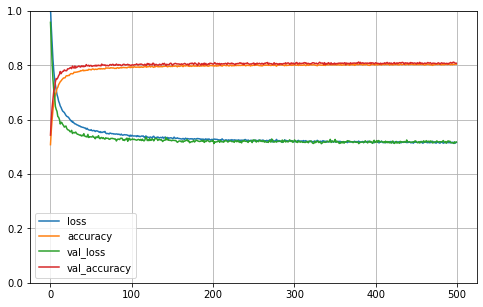

In [83]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [84]:
model.summary()
_, accuracy = model.evaluate(x_val, encoded_val_y)
print('Accuracy: %.2f' % (accuracy*100)+"%")

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 128)               1152      
_________________________________________________________________
dropout_32 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_33 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_34 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 128)              

## Regression

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

lin_reg = LinearRegression()
lin_reg.fit(x_train_reg, y_train_reg)

print('Coefficients: \n', lin_reg.coef_)

val_y_pred = lin_reg.predict(x_val_reg)
print('Mean squared error Validation: %.2f' % mean_squared_error(y_val_reg, val_y_pred))
# print('Coefficient of determination Validation: %.2f' % r2_score(y_val_reg, val_y_pred))
print('Coefficient of determination (R2) Validation: %.4f' % lin_reg.score(x_val_reg,y_val_reg))


train_y_pred = lin_reg.predict(x_train_reg)
print('Mean squared error Train: %.2f' % mean_squared_error(y_train_reg, train_y_pred))
# print('Coefficient of determination Train: %.2f' % r2_score(y_train_reg, train_y_pred))
print('Coefficient of determination (R2) Train: %.4f' % lin_reg.score(x_train_reg, y_train_reg))


print("====Polynomial")
# Linear regression with polynomial transformation of attributes. best result is received 
# within the polynomial of degree 3, as degree 4 starts to overfit.
poly = PolynomialFeatures(degree=3)
x_train_trans = poly.fit_transform(x_train_reg)
x_val_trans = poly.fit_transform(x_val_reg)

clf = LinearRegression()
clf.fit(x_train_trans, y_train_reg)

# print('Coefficients: \n', clf.coef_)

val_y_pred = clf.predict(x_val_trans)
print('Mean squared error Validation: %.2f' % mean_squared_error(y_val_reg, val_y_pred))
# print('Coefficient of determination Validation: %.2f' % r2_score(y_val_reg, val_y_pred))
print('Coefficient of determination (R2) Validation: %.4f' % clf.score(x_val_trans,y_val_reg))


train_y_pred = clf.predict(x_train_trans)
print('Mean squared error Train: %.2f' % mean_squared_error(y_train_reg, train_y_pred))
# print('Coefficient of determination Train: %.2f' % r2_score(y_train_reg, train_y_pred))
print('Coefficient of determination (R2) Train: %.4f' % clf.score(x_train_trans, y_train_reg))

Coefficients: 
 [[ -0.11154779  -0.45409909   1.31122243 -61.84156159  -0.33043453
   -1.88890682  64.11250977   0.10850876]]
Mean squared error Validation: 55.05
Coefficient of determination (R2) Validation: 0.0549
Mean squared error Train: 49.99
Coefficient of determination (R2) Train: 0.0506
====Polynomial
Mean squared error Validation: 46.12
Coefficient of determination (R2) Validation: 0.2083
Mean squared error Train: 39.90
Coefficient of determination (R2) Train: 0.2423


In [29]:
from sklearn.kernel_ridge import KernelRidge

ridg_reg = Ridge()
ridg_reg.fit(x_train_reg, y_train_reg)

print('Coefficients: \n', ridg_reg.coef_)

val_y_pred = ridg_reg.predict(x_val_reg)
print('Mean squared error Validation: %.2f' % mean_squared_error(y_val_reg, val_y_pred))
# print('Coefficient of determination Validation: %.2f' % r2_score(y_val_reg, val_y_pred))
print('Coefficient of determination (R2) Validation: %.4f' % ridg_reg.score(x_val_reg,y_val_reg))

train_y_pred = ridg_reg.predict(x_train_reg)
print('Mean squared error Train: %.2f' % mean_squared_error(y_train_reg, train_y_pred))
# print('Coefficient of determination Train: %.2f' % r2_score(y_train_reg, train_y_pred))
print('Coefficient of determination (R2) Train: %.4f' % ridg_reg.score(x_train_reg, y_train_reg))

print("===========Polynomial Ridge")


poly = PolynomialFeatures(degree=3)
x_train_trans = poly.fit_transform(x_train_reg)
x_val_trans = poly.fit_transform(x_val_reg)
clf = Ridge()
clf.fit(x_train_trans, y_train_reg)

# print('Coefficients: \n', clf.coef_)

val_y_pred = clf.predict(x_val_trans)
print('Mean squared error Validation: %.2f' % mean_squared_error(y_val_reg, val_y_pred))
# print('Coefficient of determination Validation: %.2f' % r2_score(y_val_reg, val_y_pred))
print('Coefficient of determination (R2) Validation: %.4f' % clf.score(x_val_trans,y_val_reg))


train_y_pred = clf.predict(x_train_trans)
print('Mean squared error Train: %.2f' % mean_squared_error(y_train_reg, train_y_pred))
# print('Coefficient of determination Train: %.2f' % r2_score(y_train_reg, train_y_pred))
print('Coefficient of determination (R2) Train: %.4f' % clf.score(x_train_trans, y_train_reg))

Coefficients: 
 [[-0.11221821 -0.46415644  1.33016167 -2.39170504 -0.32978879  1.0147617
   4.1897377   0.10983794]]
Mean squared error Validation: 55.05
Coefficient of determination (R2) Validation: 0.0549
Mean squared error Train: 50.00
Coefficient of determination (R2) Train: 0.0504
===========Polynomial Ridge
Mean squared error Validation: 47.23
Coefficient of determination (R2) Validation: 0.1892
Mean squared error Train: 40.54
Coefficient of determination (R2) Train: 0.2302


In [31]:
lasso_reg = Lasso()
lasso_reg.fit(x_train_reg, y_train_reg)

print('Coefficients: \n', lasso_reg.coef_)

val_y_pred = lasso_reg.predict(x_val_reg)
print('Mean squared error Validation: %.2f' % mean_squared_error(y_val_reg, val_y_pred))
# print('Coefficient of determination Validation: %.2f' % r2_score(y_val_reg, val_y_pred))
print('Coefficient of determination (R2) Validation: %.4f' % lasso_reg.score(x_val_reg,y_val_reg))

train_y_pred = lasso_reg.predict(x_train_reg)
print('Mean squared error Train: %.2f' % mean_squared_error(y_train_reg, train_y_pred))
# print('Coefficient of determination Train: %.2f' % r2_score(y_train_reg, train_y_pred))
print('Coefficient of determination (R2) Train: %.4f' % lasso_reg.score(x_train_reg, y_train_reg))

Coefficients: 
 [-0.       -0.        0.        0.250944 -0.        0.        0.
  0.      ]
Mean squared error Validation: 57.66
Coefficient of determination (R2) Validation: 0.0101
Mean squared error Train: 52.09
Coefficient of determination (R2) Train: 0.0107


In [76]:
print(x_train_reg.shape)
model = tf.keras.Sequential()
# kernel_regularizer=regularizers.l2(0.0005)
model.add(Dense(128, input_dim=8, activation='relu', kernel_regularizer=regularizers.l2(0.00005)))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.00005)))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.00005)))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.00005)))
model.add(Dropout(0.1))
# model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.00002)))
# model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))
# learning_rate = 0.1
# global_step = tf.Variable(0, trainable=False)
# decayed_lr = tf.train.exponential_decay(learning_rate, global_step, 2, 0.99, staircase=True)
optim = tf.keras.optimizers.Adam(0.001)
model.compile(loss='mean_squared_error', optimizer=optim, metrics=['mean_squared_error'])
history = model.fit(x_train_reg, y_train_reg.values.ravel(), epochs=700, batch_size=100, validation_data = (x_val_reg, y_val_reg.values.ravel()))

(40626, 8)
Epoch 1/700
407/407 [==============================] - 1s 3ms/step - loss: 881.4963 - mean_squared_error: 881.4741 - val_loss: 84.7417 - val_mean_squared_error: 84.7194
Epoch 2/700
407/407 [==============================] - 1s 3ms/step - loss: 112.7473 - mean_squared_error: 112.7251 - val_loss: 52.1959 - val_mean_squared_error: 52.1737
Epoch 3/700
407/407 [==============================] - 1s 3ms/step - loss: 92.1609 - mean_squared_error: 92.1387 - val_loss: 45.7713 - val_mean_squared_error: 45.7489
Epoch 4/700
407/407 [==============================] - 1s 3ms/step - loss: 83.1078 - mean_squared_error: 83.0854 - val_loss: 44.7298 - val_mean_squared_error: 44.7072
Epoch 5/700
407/407 [==============================] - 1s 3ms/step - loss: 77.0774 - mean_squared_error: 77.0547 - val_loss: 39.9540 - val_mean_squared_error: 39.9313
Epoch 6/700
407/407 [==============================] - 1s 3ms/step - loss: 72.7170 - mean_squared_error: 72.6941 - val_loss: 47.6161 - val_mean_square

Epoch 50/700
407/407 [==============================] - 1s 3ms/step - loss: 29.9236 - mean_squared_error: 29.8761 - val_loss: 13.2468 - val_mean_squared_error: 13.1989
Epoch 51/700
407/407 [==============================] - 1s 3ms/step - loss: 29.2377 - mean_squared_error: 29.1895 - val_loss: 13.2370 - val_mean_squared_error: 13.1885
Epoch 52/700
407/407 [==============================] - 1s 3ms/step - loss: 29.1438 - mean_squared_error: 29.0950 - val_loss: 12.5881 - val_mean_squared_error: 12.5389
Epoch 53/700
407/407 [==============================] - 1s 3ms/step - loss: 28.7620 - mean_squared_error: 28.7123 - val_loss: 15.4200 - val_mean_squared_error: 15.3700
Epoch 54/700
407/407 [==============================] - 1s 3ms/step - loss: 28.8114 - mean_squared_error: 28.7609 - val_loss: 13.5409 - val_mean_squared_error: 13.4901
Epoch 55/700
407/407 [==============================] - 1s 3ms/step - loss: 28.3780 - mean_squared_error: 28.3268 - val_loss: 13.1364 - val_mean_squared_error: 

Epoch 99/700
407/407 [==============================] - 1s 3ms/step - loss: 23.8393 - mean_squared_error: 23.7497 - val_loss: 11.0013 - val_mean_squared_error: 10.9112
Epoch 100/700
407/407 [==============================] - 1s 3ms/step - loss: 23.6556 - mean_squared_error: 23.5650 - val_loss: 10.8357 - val_mean_squared_error: 10.7448
Epoch 101/700
407/407 [==============================] - 1s 3ms/step - loss: 23.5694 - mean_squared_error: 23.4783 - val_loss: 11.0105 - val_mean_squared_error: 10.9189
Epoch 102/700
407/407 [==============================] - 1s 3ms/step - loss: 23.3341 - mean_squared_error: 23.2421 - val_loss: 10.7972 - val_mean_squared_error: 10.7046
Epoch 103/700
407/407 [==============================] - 1s 3ms/step - loss: 23.4866 - mean_squared_error: 23.3935 - val_loss: 12.0507 - val_mean_squared_error: 11.9571
Epoch 104/700
407/407 [==============================] - 1s 3ms/step - loss: 23.0801 - mean_squared_error: 22.9859 - val_loss: 11.5445 - val_mean_squared_er

407/407 [==============================] - 1s 3ms/step - loss: 21.1588 - mean_squared_error: 21.0329 - val_loss: 10.1764 - val_mean_squared_error: 10.0503
Epoch 148/700
407/407 [==============================] - 1s 3ms/step - loss: 21.3935 - mean_squared_error: 21.2671 - val_loss: 10.0250 - val_mean_squared_error: 9.8984
Epoch 149/700
407/407 [==============================] - 1s 3ms/step - loss: 21.5244 - mean_squared_error: 21.3976 - val_loss: 11.0630 - val_mean_squared_error: 10.9360
Epoch 150/700
407/407 [==============================] - 1s 3ms/step - loss: 21.0726 - mean_squared_error: 20.9451 - val_loss: 10.1569 - val_mean_squared_error: 10.0289
Epoch 151/700
407/407 [==============================] - 1s 3ms/step - loss: 20.6420 - mean_squared_error: 20.5138 - val_loss: 10.1676 - val_mean_squared_error: 10.0392
Epoch 152/700
407/407 [==============================] - 1s 3ms/step - loss: 20.8397 - mean_squared_error: 20.7109 - val_loss: 10.2134 - val_mean_squared_error: 10.0842
E

407/407 [==============================] - 1s 3ms/step - loss: 19.6523 - mean_squared_error: 19.4976 - val_loss: 10.2122 - val_mean_squared_error: 10.0573
Epoch 196/700
407/407 [==============================] - 1s 3ms/step - loss: 19.1936 - mean_squared_error: 19.0384 - val_loss: 10.3891 - val_mean_squared_error: 10.2338
Epoch 197/700
407/407 [==============================] - 1s 3ms/step - loss: 19.3030 - mean_squared_error: 19.1474 - val_loss: 9.5283 - val_mean_squared_error: 9.3723
Epoch 198/700
407/407 [==============================] - 1s 3ms/step - loss: 19.2934 - mean_squared_error: 19.1372 - val_loss: 10.3419 - val_mean_squared_error: 10.1853
Epoch 199/700
407/407 [==============================] - 1s 3ms/step - loss: 19.4393 - mean_squared_error: 19.2822 - val_loss: 9.9754 - val_mean_squared_error: 9.8182
Epoch 200/700
407/407 [==============================] - 1s 3ms/step - loss: 19.4886 - mean_squared_error: 19.3311 - val_loss: 10.9729 - val_mean_squared_error: 10.8151
Epoc

Epoch 244/700
407/407 [==============================] - 1s 3ms/step - loss: 18.2278 - mean_squared_error: 18.0497 - val_loss: 9.9984 - val_mean_squared_error: 9.8201
Epoch 245/700
407/407 [==============================] - 1s 3ms/step - loss: 17.8089 - mean_squared_error: 17.6305 - val_loss: 9.8306 - val_mean_squared_error: 9.6520
Epoch 246/700
407/407 [==============================] - 1s 3ms/step - loss: 17.7857 - mean_squared_error: 17.6068 - val_loss: 9.9836 - val_mean_squared_error: 9.8046
Epoch 247/700
407/407 [==============================] - 1s 3ms/step - loss: 18.0374 - mean_squared_error: 17.8582 - val_loss: 10.2230 - val_mean_squared_error: 10.0435
Epoch 248/700
407/407 [==============================] - 1s 3ms/step - loss: 17.8482 - mean_squared_error: 17.6686 - val_loss: 9.9920 - val_mean_squared_error: 9.8125
Epoch 249/700
407/407 [==============================] - 1s 3ms/step - loss: 17.6838 - mean_squared_error: 17.5041 - val_loss: 10.4500 - val_mean_squared_error: 10

Epoch 293/700
407/407 [==============================] - 1s 3ms/step - loss: 16.3694 - mean_squared_error: 16.1726 - val_loss: 10.3014 - val_mean_squared_error: 10.1045
Epoch 294/700
407/407 [==============================] - 1s 3ms/step - loss: 16.4035 - mean_squared_error: 16.2065 - val_loss: 10.1511 - val_mean_squared_error: 9.9539
Epoch 295/700
407/407 [==============================] - 1s 3ms/step - loss: 16.3589 - mean_squared_error: 16.1616 - val_loss: 10.1569 - val_mean_squared_error: 9.9595
Epoch 296/700
407/407 [==============================] - 1s 3ms/step - loss: 16.3628 - mean_squared_error: 16.1651 - val_loss: 10.0782 - val_mean_squared_error: 9.8802
Epoch 297/700
407/407 [==============================] - 1s 3ms/step - loss: 16.2743 - mean_squared_error: 16.0763 - val_loss: 10.0358 - val_mean_squared_error: 9.8375
Epoch 298/700
407/407 [==============================] - 1s 3ms/step - loss: 16.2208 - mean_squared_error: 16.0223 - val_loss: 10.8092 - val_mean_squared_error

Epoch 342/700
407/407 [==============================] - 1s 3ms/step - loss: 15.1992 - mean_squared_error: 14.9840 - val_loss: 9.6197 - val_mean_squared_error: 9.4044
Epoch 343/700
407/407 [==============================] - 1s 3ms/step - loss: 15.3322 - mean_squared_error: 15.1167 - val_loss: 10.1330 - val_mean_squared_error: 9.9171
Epoch 344/700
407/407 [==============================] - 1s 3ms/step - loss: 15.3282 - mean_squared_error: 15.1122 - val_loss: 9.8634 - val_mean_squared_error: 9.6473
Epoch 345/700
407/407 [==============================] - 1s 3ms/step - loss: 15.6449 - mean_squared_error: 15.4287 - val_loss: 10.2463 - val_mean_squared_error: 10.0298
Epoch 346/700
407/407 [==============================] - 1s 3ms/step - loss: 15.2485 - mean_squared_error: 15.0318 - val_loss: 10.2792 - val_mean_squared_error: 10.0625
Epoch 347/700
407/407 [==============================] - 1s 3ms/step - loss: 15.1702 - mean_squared_error: 14.9533 - val_loss: 10.1249 - val_mean_squared_error:

Epoch 391/700
407/407 [==============================] - 1s 3ms/step - loss: 14.0324 - mean_squared_error: 13.8018 - val_loss: 10.8237 - val_mean_squared_error: 10.5929
Epoch 392/700
407/407 [==============================] - 1s 3ms/step - loss: 14.4348 - mean_squared_error: 14.2037 - val_loss: 10.6982 - val_mean_squared_error: 10.4667
Epoch 393/700
407/407 [==============================] - 1s 3ms/step - loss: 13.8683 - mean_squared_error: 13.6367 - val_loss: 10.1343 - val_mean_squared_error: 9.9026
Epoch 394/700
407/407 [==============================] - 1s 3ms/step - loss: 14.1306 - mean_squared_error: 13.8988 - val_loss: 9.6938 - val_mean_squared_error: 9.4620
Epoch 395/700
407/407 [==============================] - 1s 3ms/step - loss: 14.1083 - mean_squared_error: 13.8763 - val_loss: 10.2048 - val_mean_squared_error: 9.9727
Epoch 396/700
407/407 [==============================] - 1s 3ms/step - loss: 14.3293 - mean_squared_error: 14.0972 - val_loss: 10.4925 - val_mean_squared_error

Epoch 440/700
407/407 [==============================] - 1s 3ms/step - loss: 13.5872 - mean_squared_error: 13.3423 - val_loss: 9.3744 - val_mean_squared_error: 9.1294
Epoch 441/700
407/407 [==============================] - 1s 3ms/step - loss: 13.5579 - mean_squared_error: 13.3126 - val_loss: 9.2542 - val_mean_squared_error: 9.0090
Epoch 442/700
407/407 [==============================] - 1s 3ms/step - loss: 13.3594 - mean_squared_error: 13.1140 - val_loss: 9.5544 - val_mean_squared_error: 9.3089
Epoch 443/700
407/407 [==============================] - 1s 3ms/step - loss: 13.6595 - mean_squared_error: 13.4139 - val_loss: 9.6997 - val_mean_squared_error: 9.4539
Epoch 444/700
407/407 [==============================] - 1s 3ms/step - loss: 13.0380 - mean_squared_error: 12.7919 - val_loss: 10.0212 - val_mean_squared_error: 9.7748
Epoch 445/700
407/407 [==============================] - 1s 3ms/step - loss: 13.1610 - mean_squared_error: 12.9145 - val_loss: 9.6235 - val_mean_squared_error: 9.37

Epoch 489/700
407/407 [==============================] - 1s 3ms/step - loss: 12.5877 - mean_squared_error: 12.3284 - val_loss: 10.2102 - val_mean_squared_error: 9.9507
Epoch 490/700
407/407 [==============================] - 1s 3ms/step - loss: 12.6361 - mean_squared_error: 12.3765 - val_loss: 10.4128 - val_mean_squared_error: 10.1530
Epoch 491/700
407/407 [==============================] - 1s 3ms/step - loss: 12.4009 - mean_squared_error: 12.1411 - val_loss: 9.4323 - val_mean_squared_error: 9.1722
Epoch 492/700
407/407 [==============================] - 1s 3ms/step - loss: 12.4920 - mean_squared_error: 12.2317 - val_loss: 10.0112 - val_mean_squared_error: 9.7510
Epoch 493/700
407/407 [==============================] - 1s 3ms/step - loss: 12.3906 - mean_squared_error: 12.1302 - val_loss: 9.8346 - val_mean_squared_error: 9.5741
Epoch 494/700
407/407 [==============================] - 1s 3ms/step - loss: 12.4387 - mean_squared_error: 12.1780 - val_loss: 9.8138 - val_mean_squared_error: 9

Epoch 538/700
407/407 [==============================] - 1s 3ms/step - loss: 11.9788 - mean_squared_error: 11.7082 - val_loss: 9.9884 - val_mean_squared_error: 9.7176
Epoch 539/700
407/407 [==============================] - 1s 3ms/step - loss: 11.9392 - mean_squared_error: 11.6683 - val_loss: 9.5999 - val_mean_squared_error: 9.3290
Epoch 540/700
407/407 [==============================] - 1s 3ms/step - loss: 12.2911 - mean_squared_error: 12.0199 - val_loss: 10.1980 - val_mean_squared_error: 9.9264
Epoch 541/700
407/407 [==============================] - 1s 3ms/step - loss: 11.9281 - mean_squared_error: 11.6566 - val_loss: 9.5621 - val_mean_squared_error: 9.2906
Epoch 542/700
407/407 [==============================] - 1s 3ms/step - loss: 11.8335 - mean_squared_error: 11.5616 - val_loss: 10.1129 - val_mean_squared_error: 9.8409
Epoch 543/700
407/407 [==============================] - 1s 3ms/step - loss: 11.8673 - mean_squared_error: 11.5954 - val_loss: 9.8988 - val_mean_squared_error: 9.6

Epoch 587/700
407/407 [==============================] - 1s 3ms/step - loss: 11.2071 - mean_squared_error: 10.9257 - val_loss: 9.9621 - val_mean_squared_error: 9.6805
Epoch 588/700
407/407 [==============================] - 1s 3ms/step - loss: 10.9961 - mean_squared_error: 10.7144 - val_loss: 10.3331 - val_mean_squared_error: 10.0511
Epoch 589/700
407/407 [==============================] - 1s 3ms/step - loss: 11.3683 - mean_squared_error: 11.0864 - val_loss: 9.7344 - val_mean_squared_error: 9.4526
Epoch 590/700
407/407 [==============================] - 1s 3ms/step - loss: 11.3837 - mean_squared_error: 11.1016 - val_loss: 9.9832 - val_mean_squared_error: 9.7006
Epoch 591/700
407/407 [==============================] - 1s 3ms/step - loss: 11.0675 - mean_squared_error: 10.7849 - val_loss: 9.7291 - val_mean_squared_error: 9.4465
Epoch 592/700
407/407 [==============================] - 1s 3ms/step - loss: 11.3030 - mean_squared_error: 11.0202 - val_loss: 9.8643 - val_mean_squared_error: 9.5

Epoch 636/700
407/407 [==============================] - 1s 3ms/step - loss: 10.4167 - mean_squared_error: 10.1239 - val_loss: 9.6639 - val_mean_squared_error: 9.3709
Epoch 637/700
407/407 [==============================] - 1s 3ms/step - loss: 10.6168 - mean_squared_error: 10.3237 - val_loss: 9.9457 - val_mean_squared_error: 9.6525
Epoch 638/700
407/407 [==============================] - 1s 3ms/step - loss: 10.6798 - mean_squared_error: 10.3864 - val_loss: 10.4066 - val_mean_squared_error: 10.1130
Epoch 639/700
407/407 [==============================] - 1s 3ms/step - loss: 10.6970 - mean_squared_error: 10.4037 - val_loss: 10.2688 - val_mean_squared_error: 9.9758
Epoch 640/700
407/407 [==============================] - 1s 3ms/step - loss: 10.4318 - mean_squared_error: 10.1388 - val_loss: 9.7000 - val_mean_squared_error: 9.4069
Epoch 641/700
407/407 [==============================] - 1s 3ms/step - loss: 10.4128 - mean_squared_error: 10.1197 - val_loss: 10.1241 - val_mean_squared_error: 9

Epoch 685/700
407/407 [==============================] - 1s 3ms/step - loss: 9.9382 - mean_squared_error: 9.6363 - val_loss: 9.4854 - val_mean_squared_error: 9.1836
Epoch 686/700
407/407 [==============================] - 1s 3ms/step - loss: 10.4425 - mean_squared_error: 10.1404 - val_loss: 10.1147 - val_mean_squared_error: 9.8123
Epoch 687/700
407/407 [==============================] - 1s 3ms/step - loss: 9.8767 - mean_squared_error: 9.5743 - val_loss: 10.2922 - val_mean_squared_error: 9.9897
Epoch 688/700
407/407 [==============================] - 1s 3ms/step - loss: 10.0112 - mean_squared_error: 9.7087 - val_loss: 10.0288 - val_mean_squared_error: 9.7262
Epoch 689/700
407/407 [==============================] - 1s 3ms/step - loss: 10.6032 - mean_squared_error: 10.3004 - val_loss: 10.0987 - val_mean_squared_error: 9.7954
Epoch 690/700
407/407 [==============================] - 1s 3ms/step - loss: 9.9778 - mean_squared_error: 9.6744 - val_loss: 10.3993 - val_mean_squared_error: 10.0956

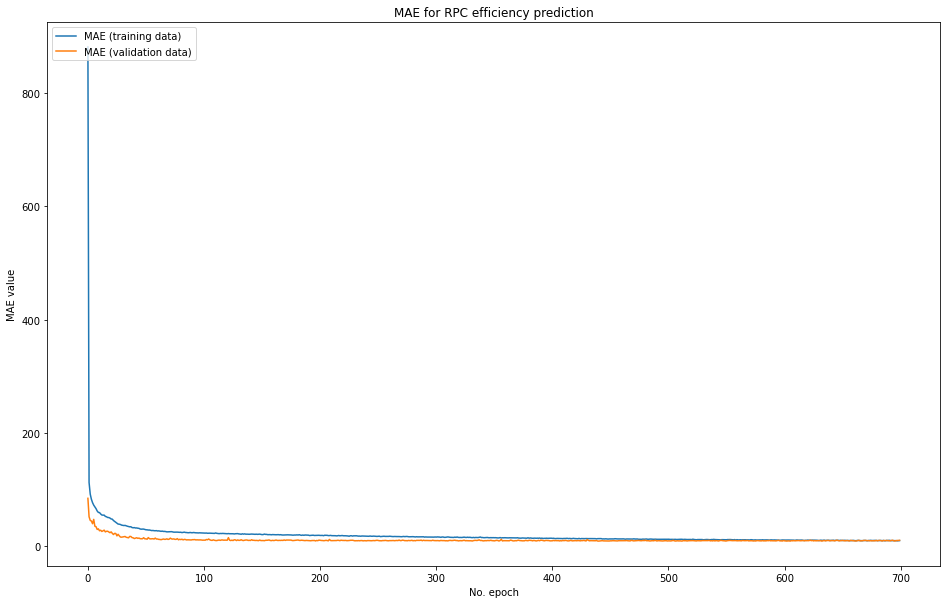

In [77]:
plt.figure(figsize=(16,10))
plt.plot(history.history['loss'], label='MAE (training data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE for RPC efficiency prediction')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [78]:
val_y_pred = model.predict(x_val_reg)
print('Mean squared error Validation: %.2f' % mean_squared_error(y_val_reg, val_y_pred))
print('Root mean squared error Validation: %.2f' % sqrt(mean_squared_error(y_val_reg, val_y_pred)))
# print('Coefficient of determination Validation: %.2f' % r2_score(y_val_reg, val_y_pred))
print('Coefficient of determination (R2) Validation: %.4f' % r2_score(y_val_reg,val_y_pred))

Mean squared error Validation: 10.26
Root mean squared error Validation: 3.20
Coefficient of determination (R2) Validation: 0.8238


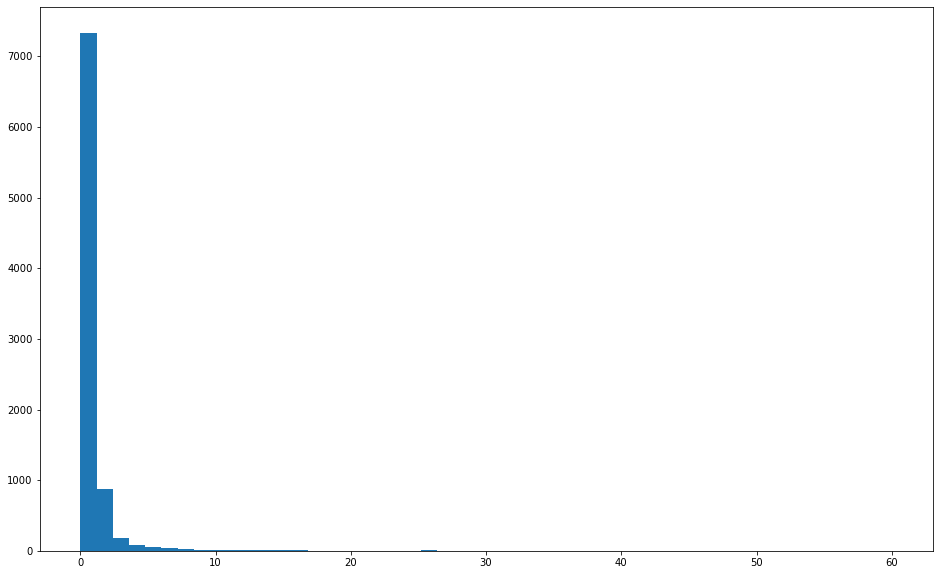

In [74]:
difference = (y_val_reg-val_y_pred).abs()
plt.figure(figsize=(16,10))
plt.hist(difference, bins=50, range=[0, 60])
plt.show() 

(58038, 16)
      run         chamber  wheel  sector  station  avg_cluster_size  \
0  321475   W-2_RB1in_S01     -2       1        1           1.88926   
1  321475  W-2_RB1out_S01     -2       1        1           1.83989   
2  321475   W-2_RB2in_S01     -2       1        2           1.99387   
3  321475  W-2_RB2out_S01     -2       1        2           1.85097   
4  321475    W-2_RB3+_S01     -2       1        3           1.86637   

   occupancy  avg_bx_dist  avg_no_of_clusters  avg_multiplicity  lumisections  \
0      85729     0.006567             1.00394           1.89670          2091   
1      75899     0.006860             1.00387           1.84701          2091   
2      91026     0.006966             1.00391           2.00167          2091   
3      78148     0.011014             1.00278           1.85611          2091   
4      36803     0.004361             1.00107           1.86836          2091   

  type  avg_efficiency  contains_zero_roll  rolls_count  fid_eff_ch_level 

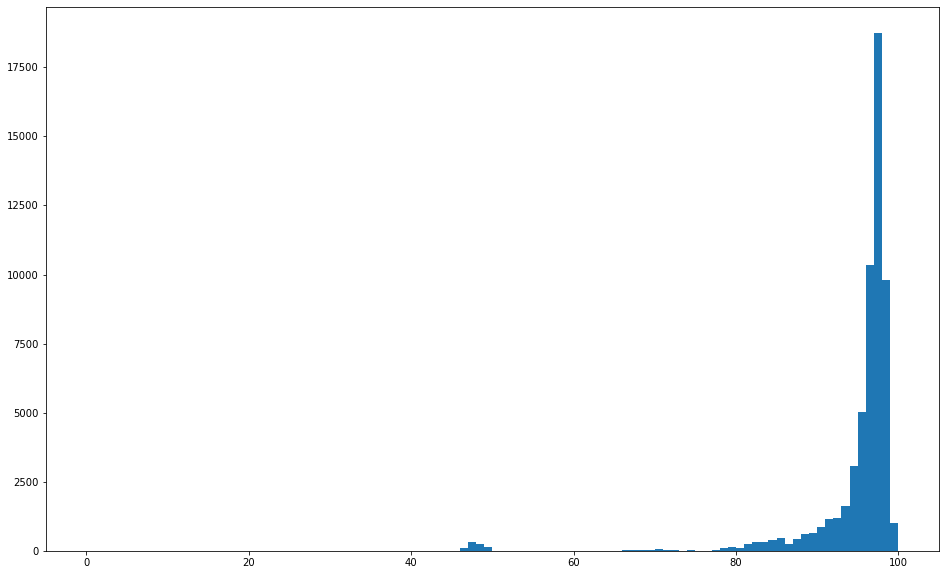

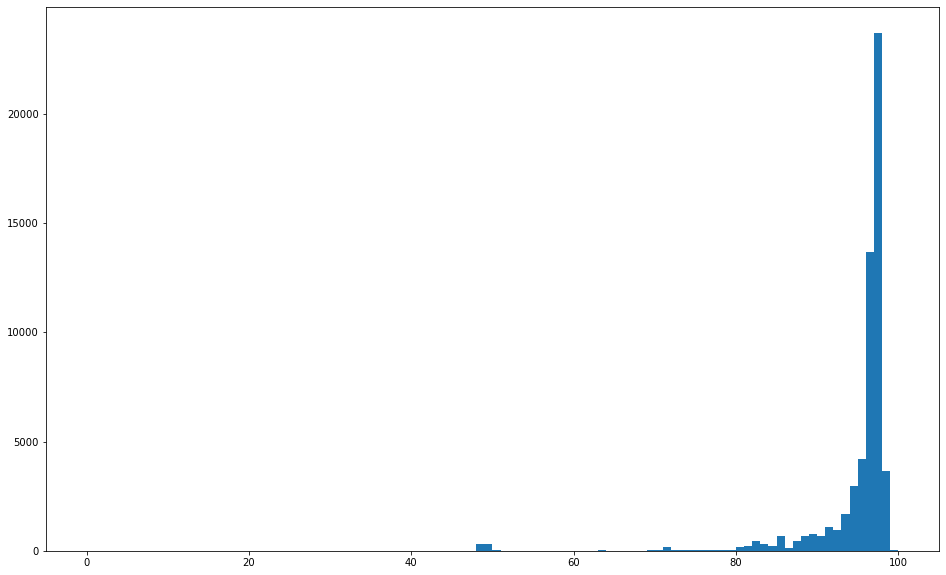

In [75]:

df_in_list = []
df_in_list.append(pd.read_csv('Collisions/'+"324209"+'/'+"324209"+'_final2.csv'))
    
run324209 = pd.concat(list_of_df)
run324209 = run324209.reset_index(drop=True)
run324209 = run324209.loc[run324209['fid_eff_ch_level'] > 0]
print(run324209.shape)
print(run324209.head(5))

plt.figure(figsize=(16,10))
plt.hist(run324209['fid_eff_ch_level'], bins=100)
plt.show()


# preparing dataset for testing predictions.
run324209['occupancy_per_LS'] = run324209['occupancy'] / run324209['lumisections']
run324209.drop(['run', 'chamber', 'type', 'contains_zero_roll', 'rolls_count', 'avg_efficiency', 'occupancy', 'lumisections', 'fid_eff_ch_level'], axis=1, inplace=True)
run324209=scaler.transform(run324209)
fid_eff_prediction = model.predict(run324209)
plt.figure(figsize=(16,10))
plt.hist(fid_eff_prediction, bins=100, range=[0, 100])
plt.show()